# Programming assignment (Linear models, Optimization)

Implementation of a linear classifier and training it using stochastic gradient descent modifications and numpy.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Two-dimensional classification



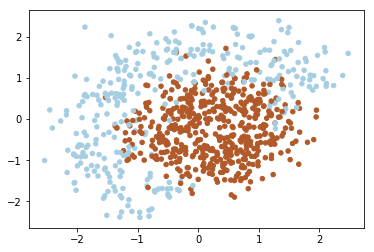

In [3]:
with open('train.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('target.npy', 'rb') as fin:
    y = np.load(fin)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

# Task

## Features

The data above isn't linearly separable. So we should add features (or use non-linear model). Note that decision line between two classes have form of circle, since that we can add quadratic features to make the problem linearly separable. The idea under this displayed on image below:

![](kernel.png)

In [4]:
def expand(X):
    """
    Adds quadratic features. 
    This expansion allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))
    X_expanded[:,0]=X[:,0]
    X_expanded[:,1]=X[:,1]
    X_expanded[:,2]=X[:,0]**2
    X_expanded[:,3]=X[:,1]**2
    X_expanded[:,4]=X[:,0]*X[:,1]
    X_expanded[:,5]=1
    return X_expanded

In [5]:
X_expanded = expand(X)

## Logistic regression

To classify objects we will obtain probability of object belongs to class '1'. To predict probability we will use output of linear model and logistic function:

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [6]:
def probability(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    Don't forget to use expand(X) function (where necessary) in this and subsequent functions.
    
    :param X: feature matrix X of shape [n_samples,6] (expanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """
    mult=-np.dot(w,X.T)
    return 1/(1+np.exp(mult))
    

In logistic regression the optimal parameters $w$ are found by cross-entropy minimization:

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i\, | \, x_i,w))}\right] $$



In [9]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    loss=-np.sum(y*np.log(probability(X,w))+(1-y)*np.log(1-probability(X,w)))/len(y)
    return loss

Since we train our model with gradient descent, we should compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla_w L = (P(y_i \, | \, x_i,w)-y_i)x_j$$


In [12]:
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    grad=np.zeros(X.shape)
    mul=(probability(X,w)-y)
    grad[:,0]=mul*X[:,0]
    grad[:,1]=mul*X[:,1]
    grad[:,2]=mul*X[:,2]
    grad[:,3]=mul*X[:,3]
    grad[:,4]=mul*X[:,4]
    grad[:,5]=mul*X[:,5]
    
    return grad

In [14]:
compute_grad(X_expanded, y, dummy_weights).shape

(826, 6)

Here's an auxiliary function that visualizes the predictions:

In [15]:
from IPython import display
import mpl_toolkits.mplot3d.axes3d as p3
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))



    
def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

In [22]:
def Accuracy(w):
    correct = 0
    length = len(y)
    prediction = (probability(X_expanded,w) > 0.5)
    correct = (prediction == y)
    my_accuracy = (np.sum(correct) / length)*100
    print ('LR Accuracy %: ', my_accuracy)


## Training
Train the classifier using stochastic gradient descent.


## Mini-batch SGD

Stochastic gradient descent just takes a random example on each iteration, calculates a gradient of the loss on it and makes a step:
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



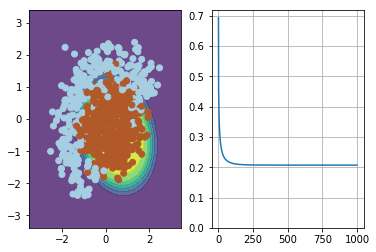

In [32]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 1 # learning rate

n_iter = 1000
batch_size = 10
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))
m=len(y)
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)
    
    w=w-(eta/m)*np.sum(compute_grad(X_expanded, y, w),axis=0)

visualize(X, y, w, loss)

plt.clf() 

In [33]:
Accuracy(w)

LR Accuracy %:  91.6464891041


## SGD with momentum

Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations as can be seen in image below. It does this by adding a fraction $\alpha$ of the update vector of the past time step to the current update vector.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$

<br>


![](sgd.png)


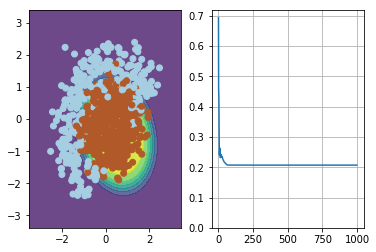

In [34]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 1 # learning rate
alpha = 0.9 # momentum
nu = np.zeros_like(w)

n_iter = 1000
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    nu=alpha*nu+(eta/m)*np.sum(compute_grad(X_expanded, y, w),axis=0)
    w=w-nu

visualize(X, y, w, loss)
plt.clf()

In [30]:
Accuracy(w)

LR Accuracy %:  91.6464891041


## RMSprop

RMSPROP algorithm, which use squared gradients to adjust learning rate:

$$ G_j^t = \alpha G_j^{t-1} + (1 - \alpha) g_{tj}^2 $$
$$ w_j^t = w_j^{t-1} - \dfrac{\eta}{\sqrt{G_j^t + \varepsilon}} g_{tj} $$

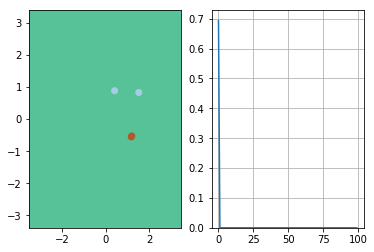

ValueError: could not broadcast input array from shape (826,826) into shape (826)

In [40]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 # learning rate
alpha = 0.9 # moving average of gradient norm squared
g2 = np.zeros(w.shape, dtype=float)
eps = 1e-8
print(w.shape)
n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)

#plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)
    
    g=compute_grad(X_expanded, y, w)
    g2=alpha*g2+(1-alpha)*g**2
    w=w-(eta)*g/(np.sqrt(g2+eps))
visualize(X, y, w, loss)
#plt.clf()